In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import img_to_array
import insightface.Arcface as Arcface
import yolo_v3.face_detection as face_detection


ModuleNotFoundError: No module named 'cv2'

## 1. Load Pretrain Model

### Arc Face

In [9]:
arc_model = Arcface.loadModel('insightface/arcface_weights.h5')
arc_model.summary()

ModuleNotFoundError: No module named 'cv2'

## Preprocess image

In [21]:
#preprocess of data
def preprocess(path, size):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image
def preprocess_image(image, size):
    weight, height = image.shape[1], image.shape[0]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image, weight, height


## 2. Test Recognize 1 image (ArcFace)

1. Forward all image from Database to ArcFace model ==> database vector
2. Forward query image to ArcFace model ==> query vector
3. Compare query vector for each database vector (cosine similarity, abs, mse) ==> result


### Get Database vector

In [22]:
def inherent_database(root_path = 'faces_database'):
    images_name = []
    images_embedding = []
    for folder in os.listdir(root_path):
        if os.path.isdir(root_path + "/" + folder):
            for name in os.listdir(root_path + "/" + folder):
                if name.endswith(("jpg", "png", "jpeg")):
                    path = f"{root_path}/{folder}/{name}"
                    image = preprocess(path, (112, 112))           
                    images_embedding.append(arc_model.predict(image)[0, :])
                    images_name.append(name.split('.')[0])
    images_embedding = np.array(images_embedding)
    images_name = np.array(images_name)

    return images_name, images_embedding/np.linalg.norm(images_embedding, axis=1, keepdims=True)       
            
names_database, embeddings_database = inherent_database("faces_database")   
                    

In [23]:
print(embeddings_database.shape)
print(names_database.shape)

(37, 512)
(37,)


### Forward Query image

In [24]:
query_image_path = r"test_face/nhut_duy_test.jpg"
query_image = preprocess(query_image_path, (112, 112))
ebd_query = arc_model.predict(query_image)[0, :]
ebd_query = ebd_query/np.linalg.norm(ebd_query)



### Compare and get result

#### Cosine Similarity

In [25]:
cosine_measure = embeddings_database.dot(ebd_query.T)
print(names_database[cosine_measure.argmax()])

nhut_duy


#### Mean square error

In [26]:
mse_measure = np.linalg.norm(embeddings_database - ebd_query, axis=-1)
print(names_database[mse_measure.argmin()])

nhut_duy


### Bounding box face 

In [29]:
path_query = r'test_face/nhut_duy_full_body.jpg'
orgimg = cv2.imread(path_query)  # BGR 
bboxs = [[460, 90, 665, 350]] #

for i in range(len(bboxs)):
    x1, y1, x2, y2 = bboxs[i]
    roi = orgimg[y1:y2, x1:x2]
    roi, _, _ = preprocess_image(roi, (112,112))
    
    ebd_query = arc_model.predict(roi)[0, :]
    ebd_query = ebd_query/np.linalg.norm(ebd_query)
    
    scores = (ebd_query @ embeddings_database.T)
    id_min = np.argmax(scores)
    score = scores[id_min]
    name = names_database[id_min]
    
    if score < 0.2:
        caption= "UN_KNOWN"
    else:
        caption = f"{name.upper()}:{score:.2f}"

    t_size = cv2.getTextSize(caption, cv2.FONT_HERSHEY_PLAIN, 2, 2)[0]
    cv2.rectangle(orgimg, (x1, y1), (x2, y2), (0, 146, 230), 3)
    cv2.rectangle(
        orgimg, (x1, y1), (x1 + t_size[0], y1 + t_size[1]), (0, 146, 230), -1)
    cv2.putText(orgimg, caption, (x1, y1 + t_size[1]), cv2.FONT_HERSHEY_PLAIN, 2, [255, 255, 255], 2)

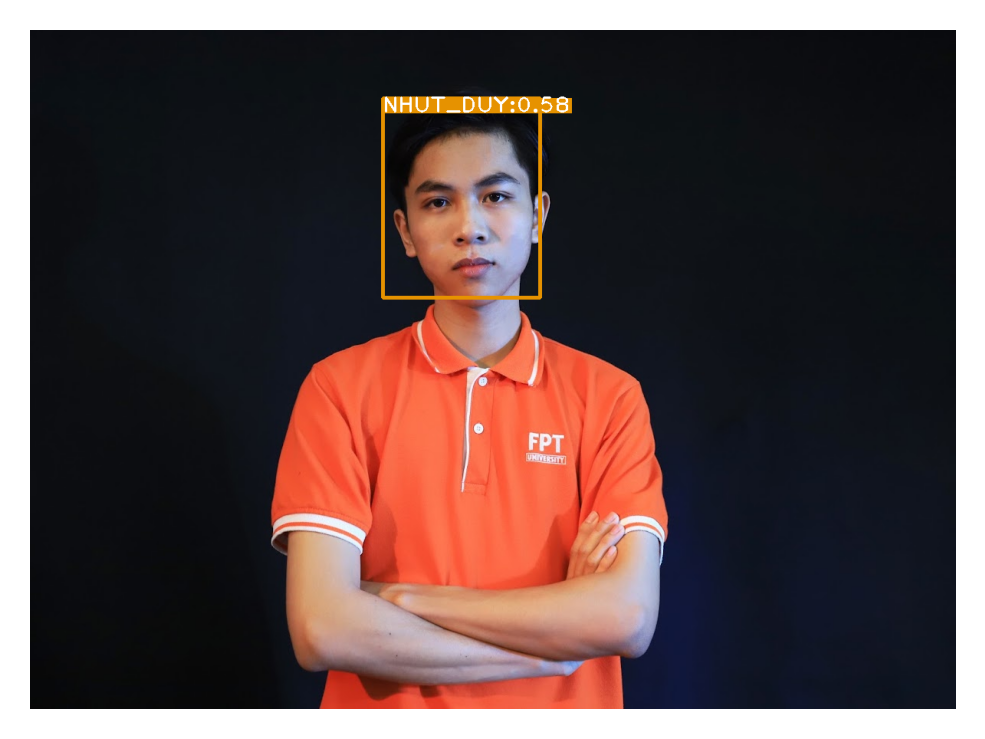

In [30]:
plt.figure(figsize=(5, 3), dpi=300)
plt.axis('off')
plt.imshow(orgimg[:,:,::-1]);

## 3.Test Recognize 1 Image (ArcFace + YoloV3)
1. Forward all image in database to ArcFace =>  database vector 
2. Crop image by YoloV3 and forward to ArcFace => query vector
3. Compare vector query and database vectors (cosine simirity, abs, mse, ...) => result

### Get Database Vector

In [195]:
def inherent_database(root_path = 'faces_database'):
    images_name = []
    images_embedding = []
    for folder in os.listdir(root_path):
        if os.path.isdir(root_path + "/" + folder):
            for name in os.listdir(root_path + "/" + folder):
                if name.endswith(("jpg", "png", "jpeg")):
                    path = f"{root_path}/{folder}/{name}"
                    image = preprocess(path, (112, 112))           
                    images_embedding.append(arc_model.predict(image)[0, :])
                    images_name.append(name.split('.')[0])
    images_embedding = np.array(images_embedding)
    images_name = np.array(images_name)

    return images_name, images_embedding/np.linalg.norm(images_embedding, axis=1, keepdims=True)       
            
names_database, embeddings_database = inherent_database("faces_database")   

In [196]:
print(embeddings_database.shape)
print(names_database.shape)

(41, 512)
(41,)


### Crop Image and Forward to ArcFace

In [197]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]  

# define the probability threshold for detected objects
class_threshold = 0.6
labels = ["face"]

In [198]:
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

photo_filename = 'test_face/nhut_duy_full_body.jpg'
input_w, input_h = 640, 640
#image, image_w, image_h = face_detection.load_image_pixels(photo_filename, (input_w, input_h))
# load yolov3 model
yolo_v3_model = load_model('yolo_v3/model_yolo_v3.h5')

In [199]:
orgimg = cv2.imread(photo_filename)  # BGR
image, image_w, image_h = preprocess_image(orgimg, (input_w, input_h))
yhat = yolo_v3_model.predict(image)
# summarize the shape of the list of arrays

print([a.shape for a in yhat])

boxes = list()
for i in range(len(yhat)):
    # decode the output of the network
    boxes += face_detection.decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    
# correct the sizes of the bounding boxes for the shape of the image
face_detection.correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

# suppress non-maximal boxes
face_detection.do_nms(boxes, 0.5)  #Discard all boxes with pc less or equal to 0.5

# get the details of the detected objects
v_boxes, v_labels, v_scores = face_detection.get_boxes(boxes, labels, class_threshold)

for i in range(len(v_boxes)):
    box = v_boxes[i]
    y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
    roi = orgimg[y1:y2, x1:x2]
    roi, _, _ = preprocess_image(roi, (112, 112))
    
    ebd_query = arc_model.predict(roi)[0, :]
    ebd_query = ebd_query/np.linalg.norm(ebd_query)
    
    scores = (ebd_query @ embeddings_database.T)
    # scores = np.linalg.norm(norm_roi_emb - norm_images_emb)
    id_min = np.argmax(scores)
    score = scores[id_min]
    name = names_database[id_min]
    
    if score < 0.2:
        caption= "UN_KNOWN"
    else:
        caption = f"{name.upper()}:{score:.2f}"

    t_size = cv2.getTextSize(caption, cv2.FONT_HERSHEY_PLAIN, 2, 2)[0]
    cv2.rectangle(orgimg, (x1, y1), (x2, y2), (0, 146, 230), 3)
    cv2.rectangle(
        orgimg, (x1, y1), (x1 + t_size[0], y1 + t_size[1]), (0, 146, 230), -1)
    cv2.putText(orgimg, caption, (x1, y1 + t_size[1]), cv2.FONT_HERSHEY_PLAIN, 2, [255, 255, 255], 2)


[(1, 20, 20, 18), (1, 40, 40, 18), (1, 80, 80, 18)]


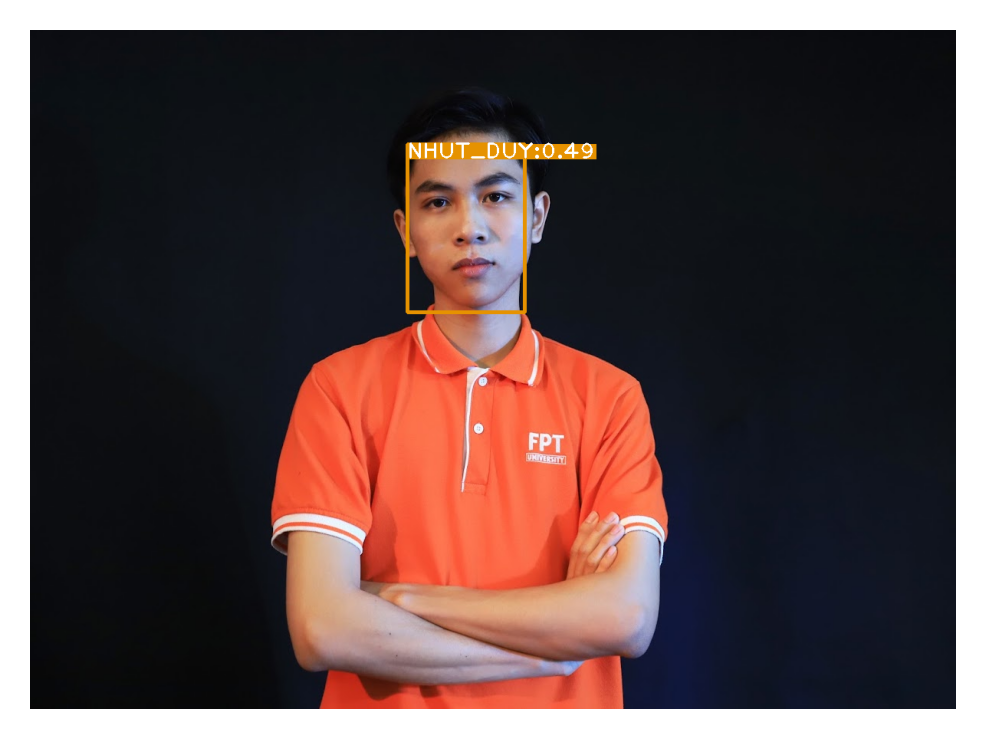

In [200]:
plt.figure(figsize=(5, 3), dpi=300)
plt.axis('off')
plt.imshow(orgimg[:,:,::-1]);

## 4. Test Recognize Video (ArcFace + Yolov3)
1. Forward all image in database to ArcFace =>  database vector 
2. Crop image by YoloV3 and forward to ArcFace by frame => query vector
3. Compare vector query and database vectors (cosine simirity, abs, mse, ...) => result for each frame

In [13]:
def inherent_database(root_path = 'faces_database'):
    images_name = []
    images_embedding = []
    for folder in os.listdir(root_path):
        if os.path.isdir(root_path + "/" + folder):
            for name in os.listdir(root_path + "/" + folder):
                if name.endswith(("jpg", "png", "jpeg")):
                    path = f"{root_path}/{folder}/{name}"
                    image = preprocess(path, (112, 112))           
                    images_embedding.append(arc_model.predict(image)[0, :])
                    images_name.append(name.split('.')[0])
    images_embedding = np.array(images_embedding)
    images_name = np.array(images_name)

    return images_name, images_embedding/np.linalg.norm(images_embedding, axis=1, keepdims=True)       
            
names_database, embeddings_database = inherent_database("faces_database")   

In [14]:
print(names_database.shape)
print(embeddings_database.shape)

(32,)
(32, 512)


In [15]:
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

input_w, input_h = 640, 640
# load yolov3 model
yolo_v3_model = load_model('yolo_v3/model_yolo_v3.h5')
labels = ["face"]


In [16]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]  

# define the probability threshold for detected objects
class_threshold = 0.6

In [17]:
l = []
fps = 25
numsecond = 10
# Create read video instance
vidcap = cv2.VideoCapture('test_face/test_video.mp4')
success, orgimg = vidcap.read()

out = cv2.VideoWriter('outputs/output_test_video_0_15_yoloface.mp4',cv2.VideoWriter_fourcc(*'mp4v'), fps, (orgimg.shape[1], orgimg.shape[0]))
count = 0
while success:
    
    count += 1
    success, orgimg = vidcap.read()
    print(".", end="")
    
    if not success:
        break   
    
    # if count >= numsecond * fps:
    #     break
    image, image_w, image_h = preprocess_image(orgimg, (input_w, input_h))
    yhat = yolo_v3_model.predict(tf.convert_to_tensor(image))
    # summarize the shape of the list of arrays

    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += face_detection.decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
        
    # correct the sizes of the bounding boxes for the shape of the image
    face_detection.correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

    # suppress non-maximal boxes
    face_detection.do_nms(boxes, 0.5)  #Discard all boxes with pc less or equal to 0.5

    # get the details of the detected objects
    v_boxes, v_labels, v_scores = face_detection.get_boxes(boxes, labels, class_threshold)
    
    if len(v_boxes) <= 0:
        continue
    
    faces = np.zeros((len(v_boxes), 112, 112, 3), dtype=np.float32)
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        roi = orgimg[y1:y2, x1:x2]
        if(all(roi.shape) == 0):
            continue
        roi, _, _ = preprocess_image(roi, (112, 112))
        faces[i] = roi

    ebd_query = arc_model.predict(tf.convert_to_tensor(faces))
    ebd_query = ebd_query/np.linalg.norm(ebd_query)

    scores = (ebd_query @ embeddings_database.T)
    idxs = np.argmax(scores, axis=-1)


    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        score = scores[i, idxs[i]] 
        name = names_database[idxs[i]]
        l.append(score)
        if score <= 0.15:
            caption= "UN_KNOWN"
        else:
            caption = f"{name.upper()}:{score:.2f}"

        t_size = cv2.getTextSize(caption, cv2.FONT_HERSHEY_PLAIN, 2, 2)[0]
        cv2.rectangle(orgimg, (x1, y1), (x2, y2), (0, 146, 230), 3)
        cv2.rectangle(orgimg, (x1, y1), (x1 + t_size[0], y1 + t_size[1]), (0, 146, 230), -1)
        cv2.putText(orgimg, caption, (x1, y1 + t_size[1]), cv2.FONT_HERSHEY_PLAIN, 2, [255, 255, 255], 2)
    out.write(orgimg)   
    
out.release()
vidcap.release()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

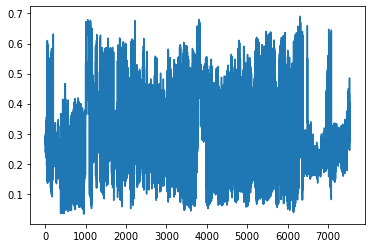

In [18]:
plt.plot(l)